# **Phần 1: Xử lý dữ liệu hình ảnh**

## **1. Setup**
### **1.0 Thư viện và một số thiết lập khác**

In [89]:
import os
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import json

import time

In [17]:
# import kagglehub

# def download_dataset():
    
    
#     # Download latest version
#     path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")
    
#     print("Path to dataset files:", path)

# # download_dataset()
# '''
# plant_names = ["apple", "blueberry", "cherry", "corn", "grape", "orange", "peach", "pepper", 
#                "potato", "raspberry", "soybean", "squash", "strawberry", "tomato"]
# '''

In [18]:
def get_plant_info(dataset_path):
    info = {}
    for dirname in os.listdir(dataset_path):
        plant_name, disease = dirname.split("___")
        plant_dataset = (disease, os.path.join(dataset_path, dirname))
        if plant_name not in info:
            info[plant_name] = [plant_dataset]
        else:
            info[plant_name].append(plant_dataset)

    return info

In [19]:
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
path = os.path.join(parent_dir, 'data', 'New Plant Diseases Dataset(Augmented)', 'New Plant Diseases Dataset(Augmented)','train')

info = get_plant_info(path)
print(json.dumps(info, indent=4))

{
    "Strawberry": [
        [
            "healthy",
            "/Users/thomas200905/Documents/Thomas/HCMUS/Third Year/Semester 8/Data Mining/labs/lab1/data/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Strawberry___healthy"
        ],
        [
            "Leaf_scorch",
            "/Users/thomas200905/Documents/Thomas/HCMUS/Third Year/Semester 8/Data Mining/labs/lab1/data/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Strawberry___Leaf_scorch"
        ]
    ],
    "Grape": [
        [
            "Black_rot",
            "/Users/thomas200905/Documents/Thomas/HCMUS/Third Year/Semester 8/Data Mining/labs/lab1/data/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Grape___Black_rot"
        ],
        [
            "Leaf_blight_(Isariopsis_Leaf_Spot)",
            "/Users/thomas200905/Documents/Thomas/HCMUS/Third Year/Semester 8/Data Mining/labs/lab1/data/New Plant Diseases Dataset

### **1.1 Đọc và thay đổi kích thước hình ảnh**

In [20]:
def load_images(dataset_path):
    images = []
    if not os.path.exists(dataset_path):
        print(f"Error: Path not found: {dataset_path}")
        
        return []
        
    for filename in os.listdir(dataset_path):
        if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
            img_path = os.path.join(dataset_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)

    return images

def resize_images(images, size=(224, 224)):
    return [cv2.resize(image, size) for image in images]

### **1.2 Hệ màu trắng đen**

In [21]:
def grayscale(image):
    red = image[:, :, 0]
    green = image[:, :, 1]
    blue = image[:, :, 2] 

    grayscale = (0.299 * red + 0.587 * green + 0.114 * blue).astype(np.uint8)
    
    return grayscale

def visualize_gray(image, saved_path=""):
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(grayscale(image), cmap="gray")
    plt.axis('off')
    
    if saved_path != "":
        plt.savefig(saved_path)
    plt.show()

### **1.3 Chuẩn hóa**

In [22]:
def normalize(image):
    image = image.astype('float32')
    mean = np.mean(image, axis=(0, 1), keepdims=True)
    std = np.std(image, axis=(0, 1), keepdims=True)
    scale = image / 255
    standardized = (image - mean) / (std + 1e-8)

    return scale, standardized

### **1.4 Edge Detection**

#### **1.4.1 Sobel**

In [23]:
def sobel(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) 
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = cv2.magnitude(sobelx, sobely)
    gradient_magnitude = cv2.convertScaleAbs(gradient_magnitude)

    return gradient_magnitude 

#### **1.4.2 Canny**

In [24]:
def canny(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 1.4)
    
    return cv2.Canny(blur, 100, 200)

#### **1.4.3 Prewitt**

In [25]:
def prewitt(image):
    kernelx = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
    kernely = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
    
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image
        
    prewittx = cv2.filter2D(gray, cv2.CV_64F, kernelx)
    prewitty = cv2.filter2D(gray, cv2.CV_64F, kernely)

    gradient_magnitude = np.sqrt(prewittx**2 + prewitty**2)
    gradient_magnitude = cv2.normalize(gradient_magnitude, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    return gradient_magnitude

#### **1.4.4 Hiển thị kết quả edge detection**

In [26]:
def visualize_edges(edge_images, saved_path=""):
    plt.figure(figsize=(10, 10))
    for idx, edge_img in enumerate(edge_images):
        plt.subplot(3, 3, idx + 1)
        if len(edge_img.shape) == 3:
            plt.imshow(edge_img) 
        else:
            plt.imshow(edge_img, cmap='gray')
        plt.axis('off')

    if saved_path != "":
        plt.savefig(saved_path)
    plt.show()

## **2. EDA**
### **2.1 Đọc dữ liệu**

In [79]:
testPath = os.path.join(parent_dir, 'data', 'test', 'test')

test_images = load_images(testPath)

### **2.2 Phân tích phân phối lớp**

In [97]:
# %% [markdown]
# #### 2.2 Bảng thống kê chi tiết phân phối mẫu trên toàn bộ tập dữ liệu (Requirement 2.1.1)
# Vì tập dữ liệu có tới 38 lớp (labels), chúng tôi sử dụng bảng thống kê chi tiết để quan sát 
# số lượng mẫu của từng loại bệnh trên tất cả các giống cây trồng.

# %%
def display_detailed_distribution_table(info):
    detailed_data = []
    
    # Duyệt qua từng loại cây
    for plant_name, diseases in info.items():
        for disease_name, folder_path in diseases:
            if os.path.exists(folder_path):
                # Đếm số lượng ảnh trong từng thư mục bệnh cụ thể
                num_imgs = len([f for f in os.listdir(folder_path) 
                              if f.lower().endswith(('.jpg', '.png', '.jpeg'))])
                
                detailed_data.append({
                    'Loại cây': plant_name.replace('_', ' ').title(),
                    'Tình trạng / Bệnh lý': disease_name.replace('_', ' ').title(),
                    'Số lượng mẫu': num_imgs
                })

    # Tạo DataFrame
    df_detailed = pd.DataFrame(detailed_data)
    
    # Sắp xếp theo tên cây và tên bệnh
    df_detailed = df_detailed.sort_values(by=['Loại cây', 'Số lượng mẫu'], ascending=[True, False])
    
    # Sử dụng style để làm bảng dễ nhìn hơn trong Notebook
    display(df_detailed.style.set_properties(**{'text-align': 'left'})
            .set_table_styles([dict(selector='th', props=[('text-align', 'left')])]))
    
    # Hiển thị tổng quát
    print(f"\n--- Tóm tắt ---")
    print(f"Tổng số giống cây: {len(info)}")
    print(f"Tổng số lớp (Labels): {len(df_detailed)}")
    print(f"Tổng số hình ảnh: {df_detailed['Số lượng mẫu'].sum():,}")
    
    return df_detailed

In [98]:
# Chạy hàm thống kê
df_detailed_stats = display_detailed_distribution_table(info)


--- Tóm tắt ---
Tổng số giống cây: 14
Tổng số lớp (Labels): 38
Tổng số hình ảnh: 70,295


In [82]:
def plot_specific_plant_distribution(info, target_plant):
    if target_plant not in info:
        print(f"Không tìm thấy dữ liệu cho cây: {target_plant}")
        return

    disease_names = []
    counts = []
    
    for disease_name, folder_path in info[target_plant]:
        if os.path.exists(folder_path):
            num_imgs = len([f for f in os.listdir(folder_path) 
                          if f.lower().endswith(('.jpg', '.png', '.jpeg'))])
            
            disease_names.append(disease_name)
            counts.append(num_imgs)

    sorted_indices = np.argsort(counts)
    disease_names = [disease_names[i] for i in sorted_indices]
    counts = [counts[i] for i in sorted_indices]

    plt.figure(figsize=(10, 6))
    colors = plt.cm.RdYlGn(np.linspace(0.3, 0.8, len(counts))) 
    
    bars = plt.barh(disease_names, counts, color=colors, edgecolor='black', alpha=0.8)
    
    plt.xlabel('Số lượng hình ảnh', fontsize=12)
    plt.title(f'Phân phối các loại bệnh trên cây {target_plant.upper()}', fontsize=14, fontweight='bold')
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    
    for index, value in enumerate(counts):
        plt.text(value + 5, index, str(value), va='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

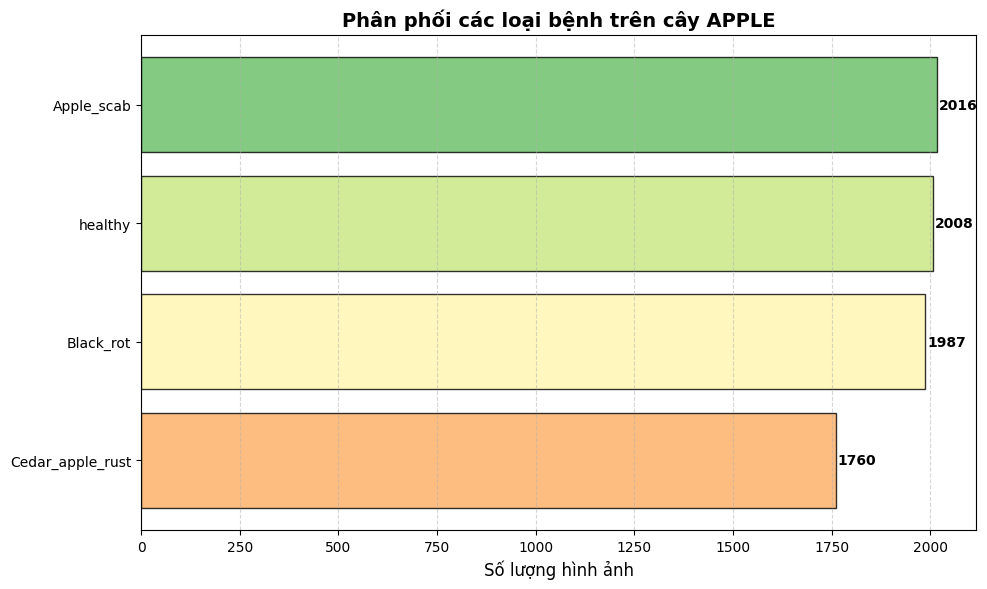

In [83]:
plot_specific_plant_distribution(info, target_plant='Apple')

-   Các lớp phân bố khá đồng đều, số lượng mẫu của lớp healthy và các loại bệnh cho mỗi loại cây dao động từ 1600 đến hơn 2000 ảnh

### **2.2 Phân tích kích thước ảnh**

In [59]:

def analyze_image_dimensions(dataset_path, num_samples=500):
    widths = []
    heights = []
    count = 0
    
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.png', '.jpeg')):
                img = cv2.imread(os.path.join(root, file))
                if img is not None:
                    h, w, _ = img.shape
                    widths.append(w)
                    heights.append(h)
                    count += 1
            if count >= num_samples:
                break
        if count >= num_samples:
            break
            
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(widths, 
                heights, 
                alpha=0.6, 
                color='darkorange')
    
    plt.title('Phân bố Kích thước Ảnh (Width vs Height)')
    plt.xlabel('Chiều rộng (px)')
    plt.ylabel('Chiều cao (px)')
    plt.grid(True, linestyle='--', alpha=0.5)
    
    unique_dims, counts = np.unique(list(zip(widths, heights)), axis=0, return_counts=True)
    dim_labels = [f"{w}x{h}" for w, h in unique_dims]
    
    plt.subplot(1, 2, 2)
    plt.bar(dim_labels, 
            counts, 
            color='steelblue')

    plt.title('Thống kê các kích thước ảnh tìm thấy')
    plt.ylabel('Số lượng')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

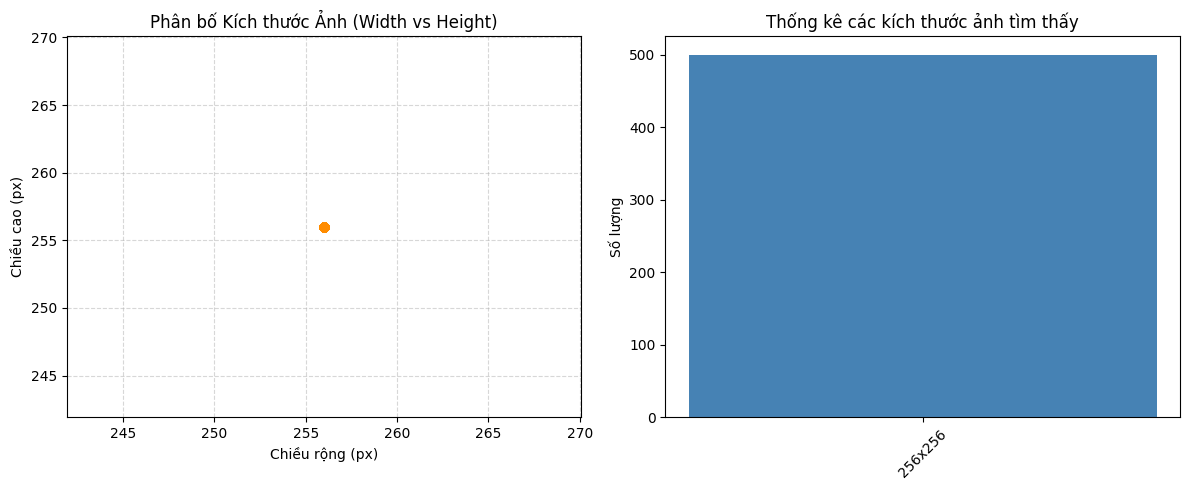

In [60]:
analyze_image_dimensions(path)

- Tất cả ảnh trong tập dữ liệu có kích thước 256x256

### **2.3 Phân tích độ sáng và độ tương phản**

In [61]:
def analyze_brightness_contrast(dataset_path, num_samples=500):
    brightness_vals = []
    contrast_vals = []
    count = 0
    
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.png', '.jpeg')):
                img = cv2.imread(os.path.join(root, file))
                if img is not None:
                    
                    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
                    brightness = hsv[:,:,2].mean()
                    brightness_vals.append(brightness)
                    
                    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                    contrast = gray.std()
                    contrast_vals.append(contrast)
                    
                    count += 1
            if count >= num_samples:
                break
        if count >= num_samples:
            break

    plt.figure(figsize=(14, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(brightness_vals, 
             bins=50, 
             color='#f1c40f', 
             edgecolor='black', 
             alpha=0.7)
    
    plt.title('Phân phối Độ sáng trung bình (Brightness)')
    plt.xlabel('Giá trị độ sáng (0-255)')
    plt.ylabel('Số lượng ảnh')
    plt.axvline(np.mean(brightness_vals), color='red', linestyle='dashed', linewidth=1, label=f'Mean: {np.mean(brightness_vals):.1f}')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.hist(contrast_vals, 
             bins=50, 
             color='#9b59b6', 
             edgecolor='black', 
             alpha=0.7)

    plt.title('Phân phối Độ tương phản (Contrast/Std Dev)')
    plt.xlabel('Độ lệch chuẩn mức xám')
    plt.axvline(np.mean(contrast_vals), color='red', linestyle='dashed', linewidth=1, label=f'Mean: {np.mean(contrast_vals):.1f}')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

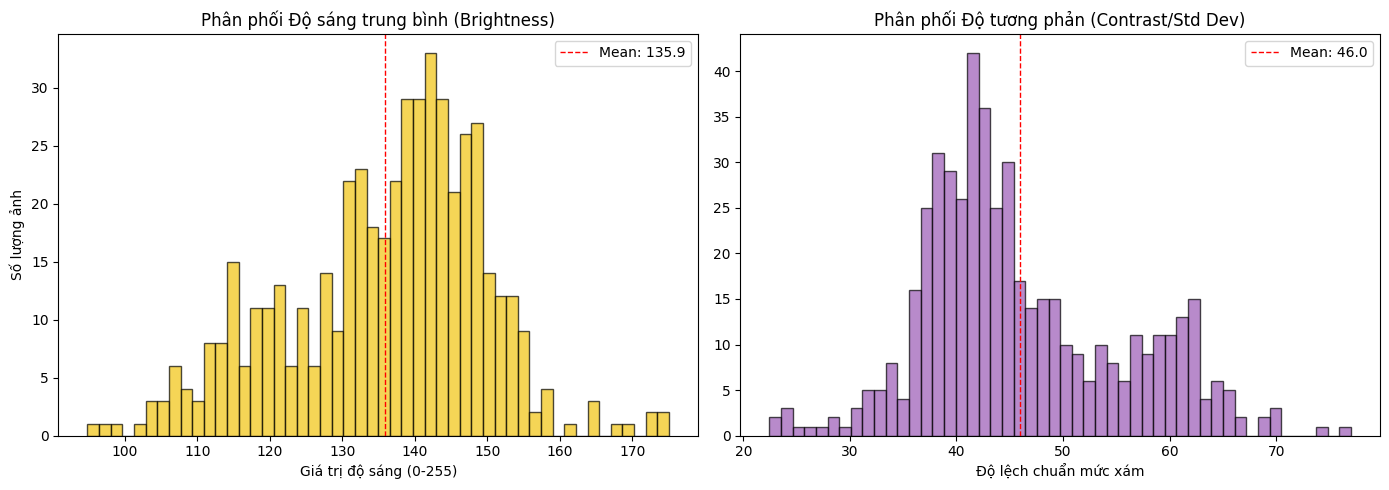

In [62]:
analyze_brightness_contrast(path)

- Độ sáng trung bình của tập dữ liệu nằm ở mức 135.9, cho thấy các ảnh có độ sáng vừa phải.
- Độ tương phản đạt giá trị trung bình 46.0, cho thấy mức độ phân biệt giữa các vùng sáng/tối trong ảnh ở mức thấp và trung bình.

## **3. Tiền xử lý**
### **3.1 Chọn kích thước ảnh**

Kích thước 32x32: 0.0593 ms
Kích thước 64x64: 0.0628 ms
Kích thước 128x128: 0.0770 ms
Kích thước 224x224: 0.1215 ms
Kích thước 256x256: 0.1281 ms
Kích thước 512x512: 0.3758 ms


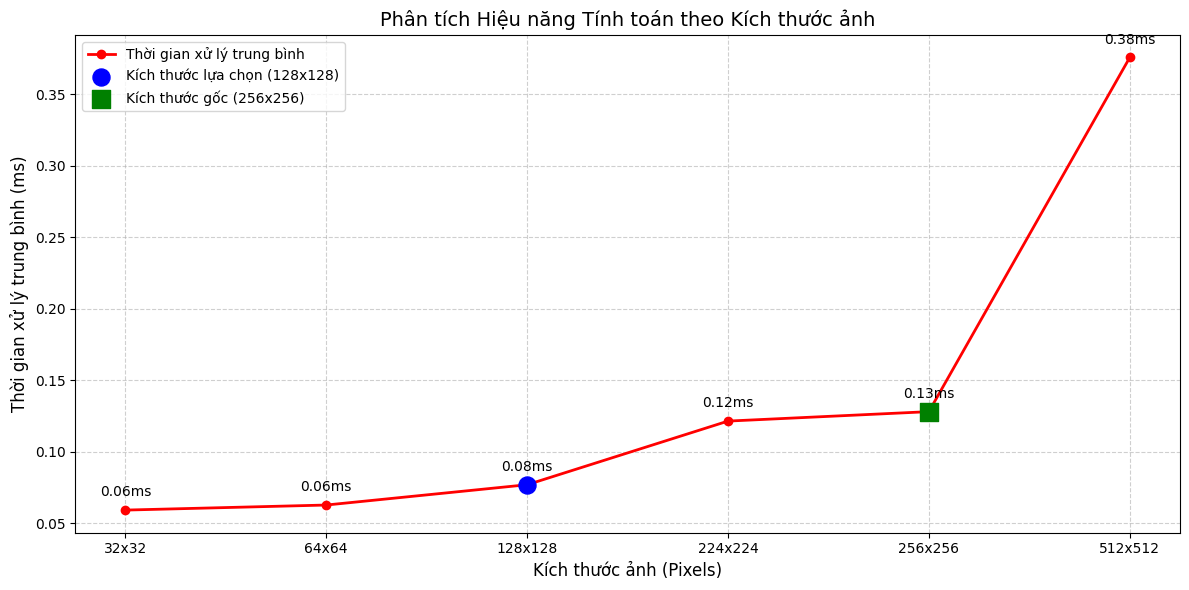

In [68]:
def analyze_size_efficiency_tradeoff(image):
    dimensions = [(32, 32), (64, 64), (128, 128), (224, 224), (256, 256), (512, 512)]
    avg_times_ms = []
    labels = [f"{d[0]}x{d[1]}" for d in dimensions]
    
    iterations = 2000
    warmup_runs = 10
    
    for size in dimensions:
        resized_img = cv2.resize(image, size)
        
        # 1. Warm-up phase (Làm nóng CPU)
        for _ in range(warmup_runs):
            gray = cv2.cvtColor(resized_img, cv2.COLOR_RGB2GRAY)
            blur = cv2.GaussianBlur(gray, (5, 5), 0)
            _ = cv2.Canny(blur, 100, 200)
            
        # 2. Measurement phase (Đo lường thực tế)
        start_time = time.perf_counter()
        for _ in range(iterations):
            gray = cv2.cvtColor(resized_img, cv2.COLOR_RGB2GRAY)
            blur = cv2.GaussianBlur(gray, (5, 5), 0)
            _ = cv2.Canny(blur, 100, 200)
        end_time = time.perf_counter()
        
        avg_time_ms = ((end_time - start_time) / iterations) * 1000
        avg_times_ms.append(avg_time_ms)
        print(f"Kích thước {size[0]}x{size[1]}: {avg_time_ms:.4f} ms")

    plt.figure(figsize=(12, 6))
    plt.plot(labels, avg_times_ms, marker='o', color='red', linewidth=2, label='Thời gian xử lý trung bình')
    
    # Đánh dấu các điểm quan trọng
    # Điểm 224x224 (Lựa chọn của đồ án)
    plt.scatter(labels[2], avg_times_ms[2], color='blue', s=150, zorder=5, label='Kích thước lựa chọn (128x128)')
    # Điểm 256x256 (Kích thước gốc)
    plt.scatter(labels[4], avg_times_ms[4], color='green', s=150, zorder=5, marker='s', label='Kích thước gốc (256x256)')
    
    plt.title('Phân tích Hiệu năng Tính toán theo Kích thước ảnh', fontsize=14)
    plt.xlabel('Kích thước ảnh (Pixels)', fontsize=12)
    plt.ylabel('Thời gian xử lý trung bình (ms)', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    
    for i, txt in enumerate(avg_times_ms):
        plt.annotate(f"{txt:.2f}ms", (labels[i], avg_times_ms[i]), textcoords="offset points", xytext=(0,10), ha='center')

    plt.tight_layout()
    plt.show()

analyze_size_efficiency_tradeoff(test_images[0])

- Khi giảm kích thước từ 256x256 xuống 128x128, thời gian xử lý ảnh giảm đáng kể từ 0.13ms xuống còn 0.08ms, giúp tiết kiệm khoảng 38% chi phí tính toán. Tuy nhiên, khi giảm xuống dưới 128x128, thời gian xử lý thay đổi rất ít (chỉ giảm thêm 0.02ms).
- Ngược lại, khi tăng kích thước từ 256x256 lên 512x512, thời gian xử lý tăng từ 0.13ms lên 0.38ms, gây áp lực lớn lên tài nguyên hệ thống.

In [74]:
def visualize_size_quality_comparison(images, num_samples=5, dimensions=[32, 64, 128, 224, 256, 512]):
    """
    Hàm hiển thị so sánh chất lượng ảnh một cách linh hoạt.
    - Squeeze=False: Đảm bảo axes luôn là ma trận 2 chiều ngay cả khi num_samples=1 hoặc len(dimensions)=1.
    - Figsize động: Tự động điều chỉnh kích thước dựa trên số lượng cột và hàng để ảnh luôn vuông vắn.
    """
    num_dims = len(dimensions)
    
    # Giới hạn số lượng mẫu nếu danh sách images truyền vào ít hơn num_samples
    num_samples = min(num_samples, len(images))
    
    # Tính toán figsize: Mỗi ảnh chiếm khoảng 3 đơn vị chiều rộng và 3 đơn vị chiều cao
    # Điều này giúp loại bỏ khoảng cách thừa khi bạn chỉ hiển thị 2 hoặc 3 cột
    width = num_dims * 3
    height = num_samples * 3
    
    # squeeze=False giúp tránh lỗi "Axes object is not subscriptable" khi chỉ có 1 hàng/cột
    fig, axes = plt.subplots(num_samples, num_dims, figsize=(width, height), squeeze=False)
    
    fig.suptitle('So sánh Chất lượng Hình ảnh theo các Kích thước khác nhau', fontsize=16, fontweight='bold', y=0.98)

    for i in range(num_samples):
        img = images[i]
        
        for j, size in enumerate(dimensions):
            # Resize ảnh
            resized = cv2.resize(img, (size, size))
            
            ax = axes[i, j]
            ax.imshow(resized)
            
            # Chỉ đặt tiêu đề cho hàng trên cùng
            if i == 0:
                ax.set_title(f"Kích thước\n{size}x{size}", fontsize=11, fontweight='bold')
            
            # Chỉ đặt nhãn mẫu cho cột ngoài cùng bên trái
            if j == 0:
                ax.set_ylabel(f"Mẫu {i+1}", fontsize=11, fontweight='bold')
                
            # Tắt trục tọa độ
            ax.set_xticks([])
            ax.set_yticks([])

    # plt.tight_layout giúp tối ưu không gian giữa các ảnh
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

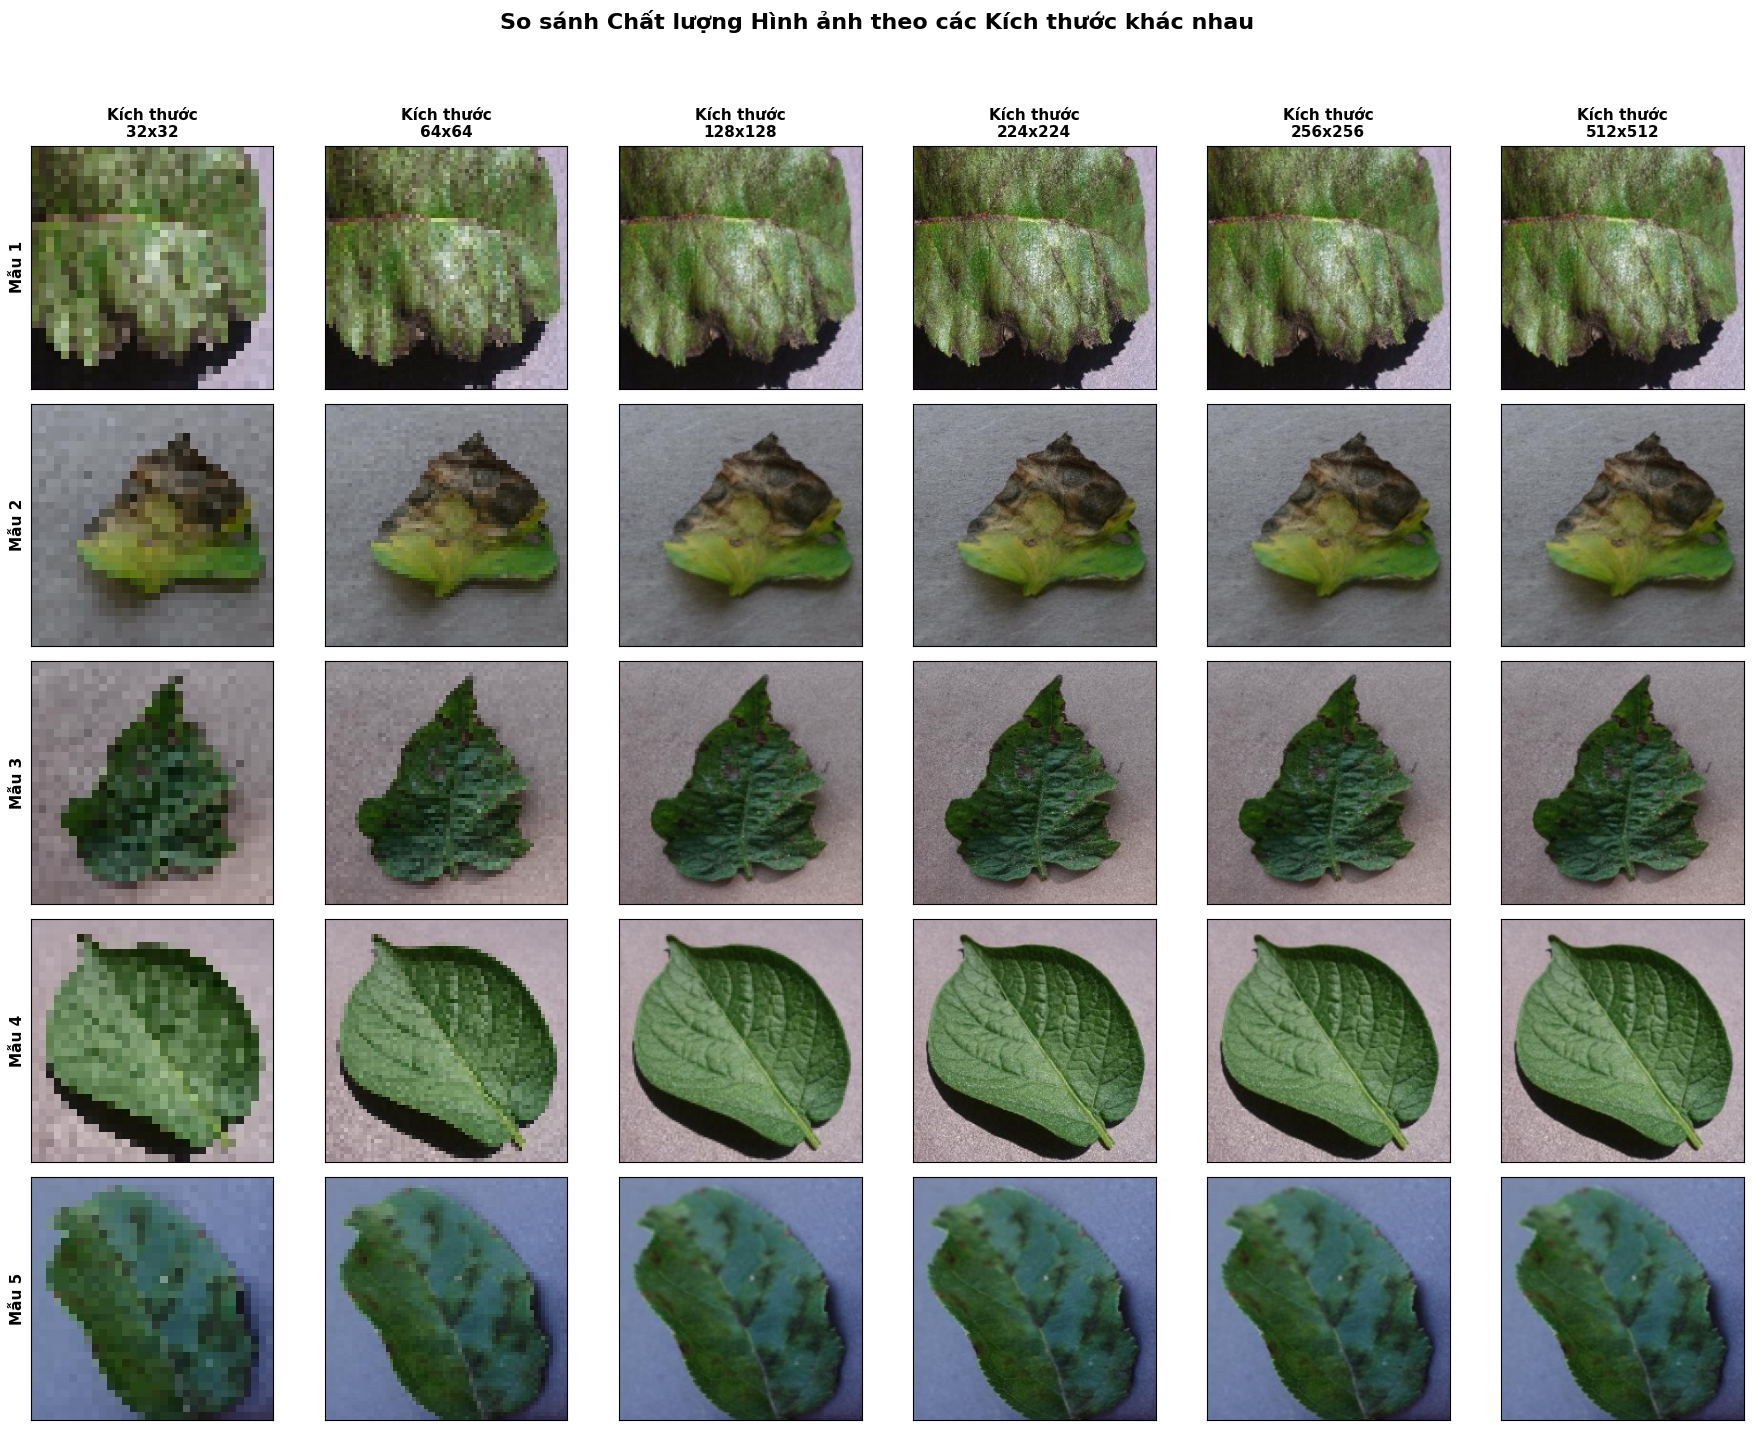

In [75]:
visualize_size_quality_comparison(test_images, num_samples=5)

- Khi so sánh giữa kích thước gốc 256x256 và 128x128, sự khác biệt về mặt thị giác là rất nhỏ. Khi giảm xuống dưới mức 128x128, hiện tượng "vỡ ảnh" bắt đầu xuất hiện rõ rệt, làm mờ đi ranh giới của vết bệnh và gây khó khăn cho việc phân loại chính xác.

**Kết luận:** Chọn kích thước 128x128

In [84]:
test_images = resize_images(test_images, (128, 128))

### **3.2 Ảnh xám**

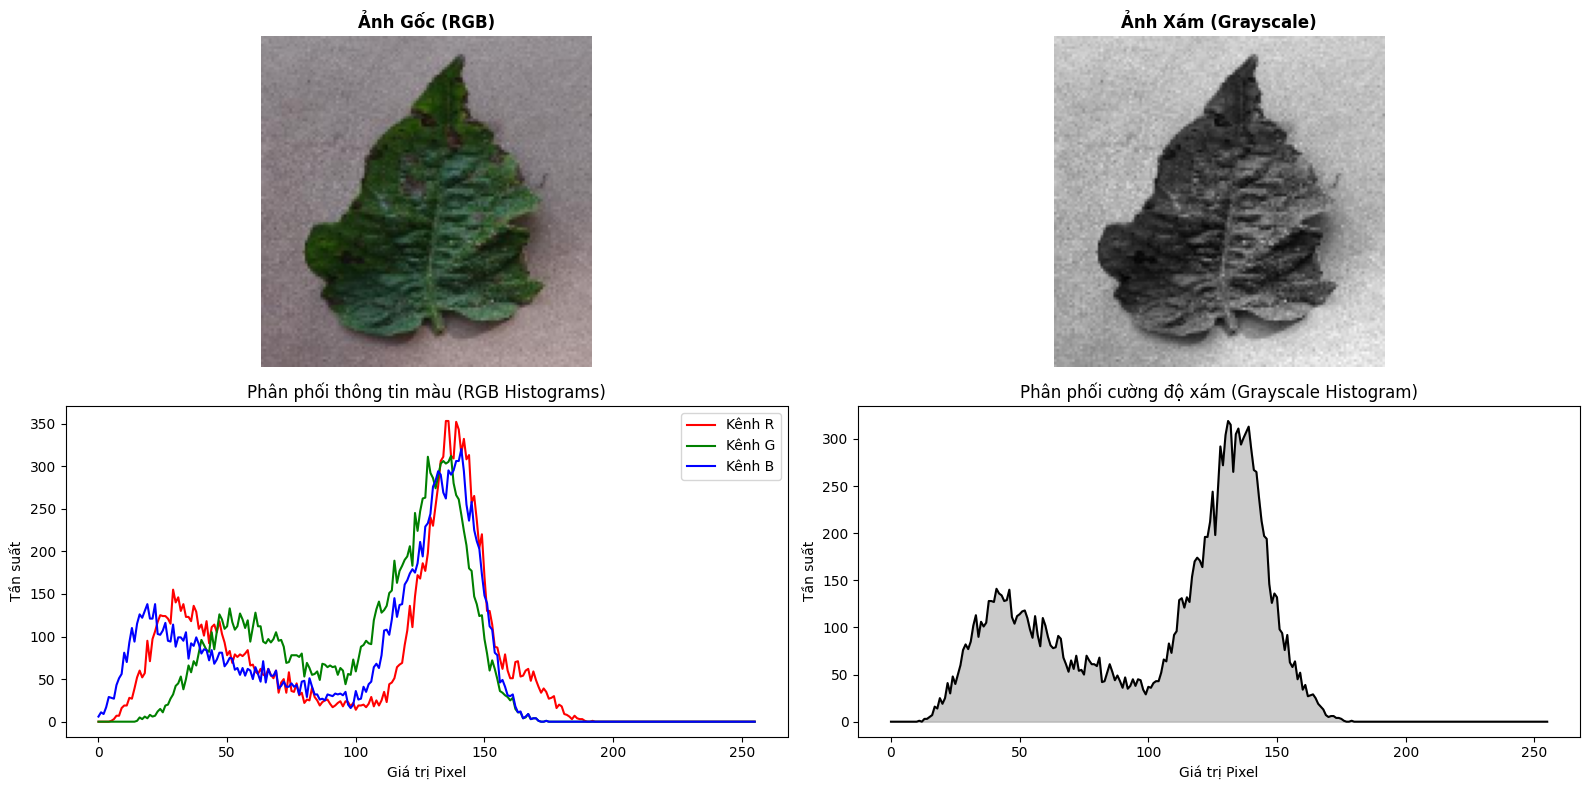

In [85]:
def analyze_grayscale_retention(image):
    gray_img = grayscale(image)
    
    # Thiết lập khung hình
    plt.figure(figsize=(16, 8))
    
    # 1. Hiển thị Ảnh Gốc và Ảnh Xám
    plt.subplot(2, 2, 1)
    plt.imshow(image)
    plt.title('Ảnh Gốc (RGB)', fontsize=12, fontweight='bold')
    plt.axis('off')
    
    plt.subplot(2, 2, 2)
    plt.imshow(gray_img, cmap='gray')
    plt.title('Ảnh Xám (Grayscale)', fontsize=12, fontweight='bold')
    plt.axis('off')
    
    # 2. Histogram Màu (RGB) - Cho thấy sự đa dạng thông tin màu
    plt.subplot(2, 2, 3)
    colors = ('r', 'g', 'b')
    for i, col in enumerate(colors):
        hist = cv2.calcHist([image], [i], None, [256], [0, 256])
        plt.plot(hist, color=col, label=f'Kênh {col.upper()}')
    plt.title('Phân phối thông tin màu (RGB Histograms)')
    plt.xlabel('Giá trị Pixel')
    plt.ylabel('Tần suất')
    plt.legend()
    
    # 3. Histogram Xám - Cho thấy sự gộp thông tin
    plt.subplot(2, 2, 4)
    hist_gray = cv2.calcHist([gray_img], [0], None, [256], [0, 256])
    plt.plot(hist_gray, color='black')
    plt.fill_between(range(256), hist_gray.flatten(), color='gray', alpha=0.4)
    plt.title('Phân phối cường độ xám (Grayscale Histogram)')
    plt.xlabel('Giá trị Pixel')
    plt.ylabel('Tần suất')
    
    plt.tight_layout()
    plt.show()

# Thực hiện phân tích trên một mẫu lá có bệnh
analyze_grayscale_retention(test_images[2])

**1. Khả năng bảo toàn thông tin:**
- Về không gian: Hệ màu xám bảo toàn các đặc trưng về hình dạng, cấu trúc gân lá và ranh giới vết bệnh.
- Về màu sắc: Các kênh màu Đỏ, Xanh lá bị gộp lại, dẫn đến việc mất đi thông tin về màu sắc.

**1. So sánh kích thước và bộ nhớ:**
- Một ảnh RGB kích thước 128x128 chiếm: $128 \times 128 \times 3 = 49,152$ đơn vị dữ liệu.
- Một ảnh Xám kích thước 128x128 chỉ chiếm: $128 \times 128 \times 1 = 16,384$ đơn vị dữ liệu.

### **3.3 Chuẩn hoá ảnh**

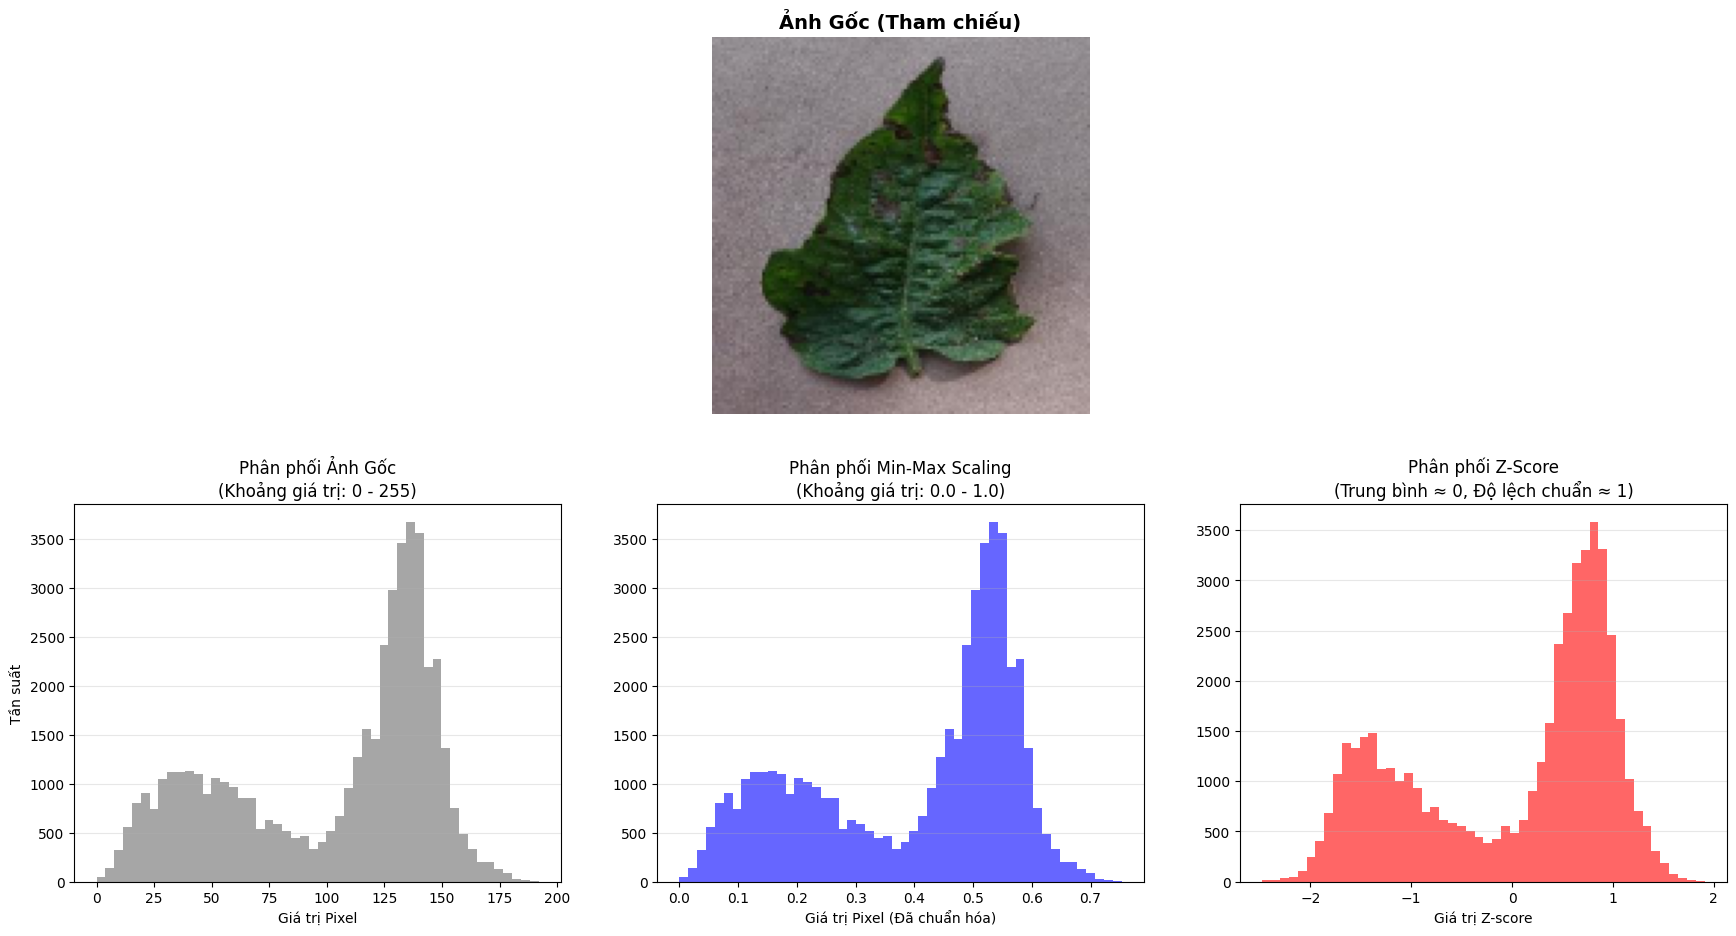

In [86]:
# %% [markdown]
# #### 5.2 Chuẩn hóa và phân tích phân phối giá trị pixel (Requirement C)
# Chúng tôi thực hiện so sánh phân phối dữ liệu giữa ảnh gốc, phương pháp Min-Max Scaling và 
# chuẩn hóa Z-Score. Mục tiêu là quan sát sự thay đổi về phạm vi giá trị (X-axis) 
# trong khi vẫn giữ nguyên cấu trúc thông tin (hình dáng phân phối).

# %%
image = test_images[2]
zero_one_scaling, standardized = normalize(image)

# Cấu hình khung hình
plt.figure(figsize=(18, 10))

# 1. Hiển thị Ảnh Gốc ở chính giữa phía trên để tham chiếu
plt.subplot(2, 3, 2)
plt.imshow(image)
plt.title('Ảnh Gốc (Tham chiếu)', fontsize=14, fontweight='bold')
plt.axis('off')

# 2. Histogram Ảnh Gốc (0-255)
plt.subplot(2, 3, 4)
plt.hist(image.ravel(), bins=50, color='gray', alpha=0.7)
plt.title('Phân phối Ảnh Gốc\n(Khoảng giá trị: 0 - 255)', fontsize=12)
plt.xlabel('Giá trị Pixel')
plt.ylabel('Tần suất')
plt.grid(axis='y', alpha=0.3)

# 3. Histogram Min-Max Scaling [0,1]
plt.subplot(2, 3, 5)
plt.hist(zero_one_scaling.ravel(), bins=50, color='blue', alpha=0.6)
plt.title('Phân phối Min-Max Scaling\n(Khoảng giá trị: 0.0 - 1.0)', fontsize=12)
plt.xlabel('Giá trị Pixel (Đã chuẩn hóa)')
plt.grid(axis='y', alpha=0.3)

# 4. Histogram Z-Score (Standardization)
plt.subplot(2, 3, 6)
plt.hist(standardized.ravel(), bins=50, color='red', alpha=0.6)
plt.title('Phân phối Z-Score\n(Trung bình ≈ 0, Độ lệch chuẩn ≈ 1)', fontsize=12)
plt.xlabel('Giá trị Z-score')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout(pad=3.0)
plt.show()

*   Cả ba biểu đồ đều có hình dạng phân phối giống nhau.
*   Về sự khác biệt của giá trị:
    *   **Ảnh gốc:** Dữ liệu trải dài từ 0 đến 255. 
    *   **Min-Max Scaling:** Đưa toàn bộ pixel về khoảng [0, 1]. 
    *   **Z-Score Standardization:** Đưa dữ liệu về trung bình bằng 0 và độ lệch chuẩn bằng 1. 

### **3.4 Edge detection**

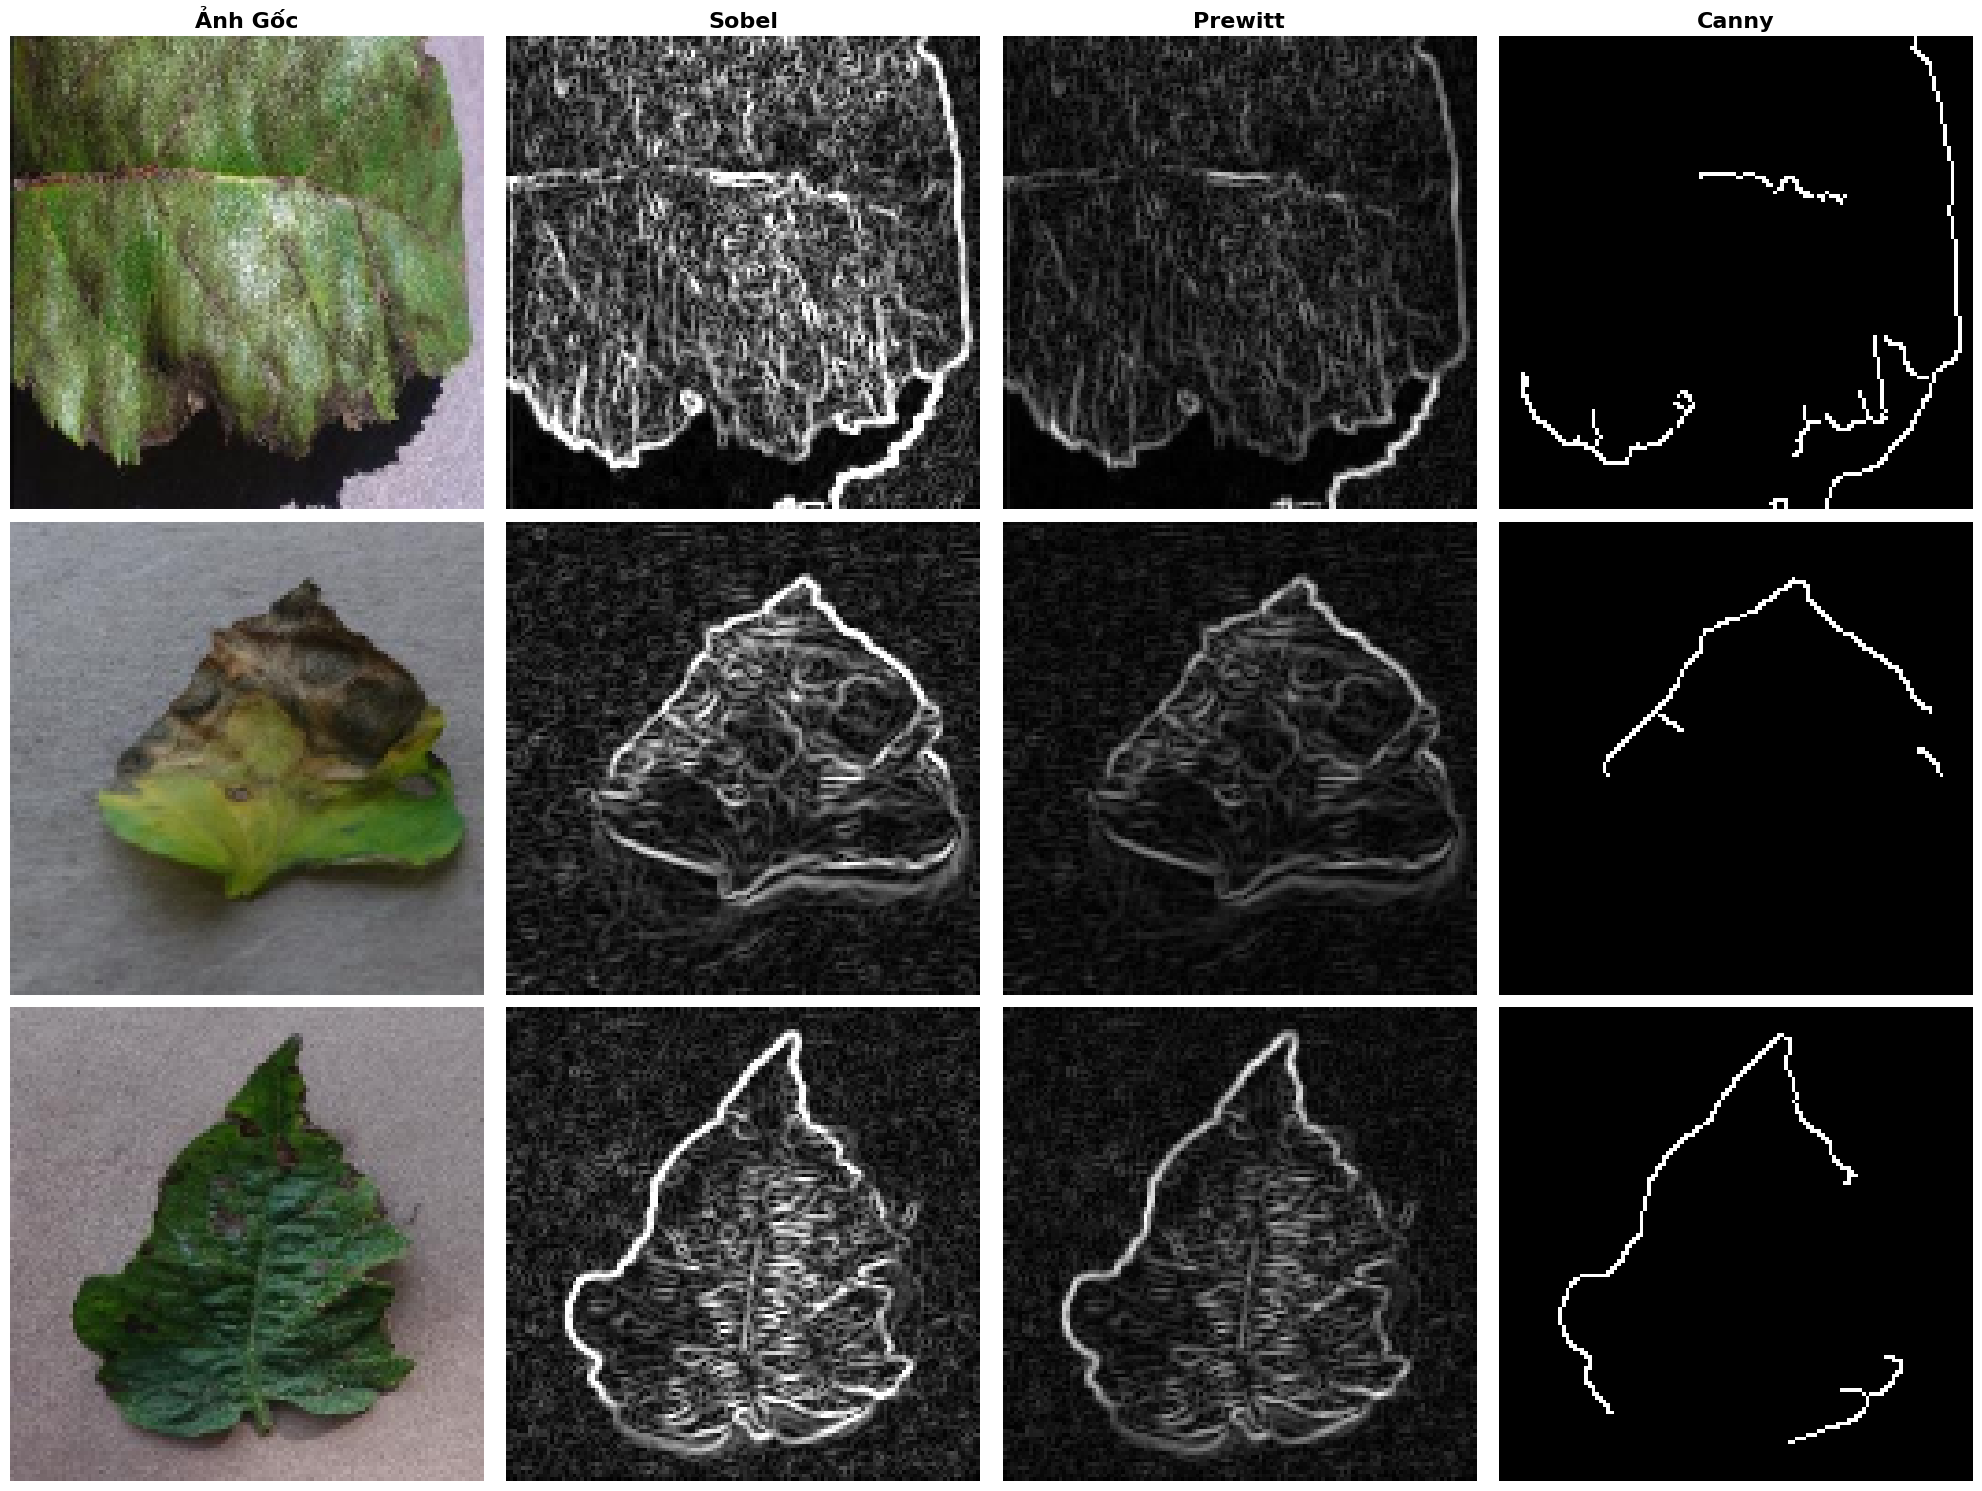

In [87]:
# %% [markdown]
# #### 4.5 So sánh các kỹ thuật tách biên trên nhiều mẫu (Requirement D)
# Chúng tôi thực hiện trích xuất biên trên 3 mẫu lá khác nhau để đánh giá tính ổn định 
# và hiệu quả của các thuật toán Sobel, Prewitt và Canny trong việc xác định cấu trúc vết bệnh.

# %%
def compare_multiple_edge_detectors(images, num_samples=3):
    # Khởi tạo khung hình (Rows = số ảnh mẫu, Cols = Gốc + 3 Thuật toán)
    fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5 * num_samples))
    
    titles = ['Ảnh Gốc', 'Sobel', 'Prewitt', 'Canny']
    
    for i in range(num_samples):
        img = images[i]
        
        # Thực hiện các phép toán tách biên
        results = [
            img,
            sobel(img),
            prewitt(img),
            canny(img)
        ]
        
        for j, result in enumerate(results):
            # Hiển thị ảnh
            if j == 0:
                axes[i, j].imshow(result) # Ảnh gốc RGB
            else:
                axes[i, j].imshow(result, cmap='gray') # Ảnh biên cạnh
                
            # Đặt tiêu đề cho hàng đầu tiên
            if i == 0:
                axes[i, j].set_title(titles[j], fontsize=16, fontweight='bold')
            
            # Đặt nhãn cho từng hàng
            if j == 0:
                axes[i, j].set_ylabel(f"Mẫu {i+1}", fontsize=14, fontweight='bold')
                
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

# Thực hiện trên 3 mẫu đầu tiên của tập test
if len(test_images) >= 3:
    compare_multiple_edge_detectors(test_images, num_samples=3)

- **Canny:** Là thuật toán tốt nhất để xác định đường viền và hình dáng tổng thể. Tuy nhiên, Canny không phát hiện được các đốm bệnh vì độ tương phản tại ranh giới vết bệnh thường không đủ lớn để vượt qua ngưỡng lọc.
- **Sobel & Prewitt:** Trích xuất được nhiều chi tiết bên trong lá hơn, nhưng lại bị nhiễu từ cấu trúc gân lá. Do đó rất khó phân biệt vùng bệnh và gân lá.